# Covid19

In [1]:
# Import Libraries
import numpy as np # For Math
import pandas as pd # For Data Visualization
import matplotlib.pyplot as plt # For Graph
import seaborn as sns # For Advence Graph

from statsmodels.tsa.arima.model import ARIMA # ARIMA is used for time series forecasting based on autoregression, differencing, and moving averages
from pandas.plotting import register_matplotlib_converters # Import a helper function to ensure matplotlib and pandas date formats work smoothly together in plots

from sklearn.linear_model import LinearRegression # Import Linear Regression model from scikit-learn
from sklearn.metrics import r2_score # R² (coefficient of determination) measures how well the regression predictions approximate the actual data

from scipy.stats import ttest_ind # Import the independent two-sample t-test function from SciPy

from sklearn.cluster import KMeans  # Imports the KMeans clustering algorithm for unsupervised learning
from sklearn.preprocessing import StandardScaler  # Imports a tool to standardize features by removing the mean and scaling to unit variance

import warnings # Handeling Error
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('covid_19_clean_complete.csv')
df.head(5)

Province/State Country/Region       Lat       Long        Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953  2020-01-22          0   
1            NaN        Albania  41.15330  20.168300  2020-01-22          0   
2            NaN        Algeria  28.03390   1.659600  2020-01-22          0   
3            NaN        Andorra  42.50630   1.521800  2020-01-22          0   
4            NaN         Angola -11.20270  17.873900  2020-01-22          0   

   Deaths  Recovered  Active             WHO Region  
0       0          0       0  Eastern Mediterranean  
1       0          0       0                 Europe  
2       0          0       0                 Africa  
3       0          0       0                 Europe  
4       0          0       0                 Africa

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  14664 non-null  object 
 1   Country/Region  49068 non-null  object 
 2   Lat             49068 non-null  float64
 3   Long            49068 non-null  float64
 4   Date            49068 non-null  object 
 5   Confirmed       49068 non-null  int64  
 6   Deaths          49068 non-null  int64  
 7   Recovered       49068 non-null  int64  
 8   Active          49068 non-null  int64  
 9   WHO Region      49068 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB


# 1. Data Understanding

In [4]:
# Data PreProcessing
# Making a variable
colm = ['Confirmed', 'Deaths', 'Recovered', 'Date']

# Check duplicates in each column individually
for col in colm:
    duplicate_values = df[col].duplicated().sum()
    print(f"Column '{col}': {duplicate_values} duplicate values")
    
# Checkin missing & duplicates values
missing_value = df[colm].isnull().sum()
missing_value

Column 'Confirmed': 38207 duplicate values
Column 'Deaths': 45428 duplicate values
Column 'Recovered': 41459 duplicate values
Column 'Date': 48880 duplicate values


Confirmed    0
Deaths       0
Recovered    0
Date         0
dtype: int64

In [5]:
# Data Types
# Checking data types
df[colm].dtypes

Confirmed     int64
Deaths        int64
Recovered     int64
Date         object
dtype: object

In [6]:
# Time Series
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].dtypes

dtype('<M8[ns]')

# 2. Descriptive Analysis

In [7]:
# Total Cases & Deaths
# Group by the country and sum confirmed and deaths
country_totals = df.groupby('Country/Region')[['Confirmed', 'Deaths']].sum().sort_values(by='Confirmed', ascending=False).head(5)

# Show the totals
print('Total Confirmed Cases and Deaths by Country:')
print(country_totals)

# Country with the highest confirmed cases
top_country_cases = country_totals['Confirmed'].idxmax()
top_cases = country_totals['Confirmed'].max()

# Country with the highest death
top_country_deaths = country_totals['Deaths'].idxmax()
top_deaths = country_totals['Deaths'].max()

print(f'Country with the highest Confrimed Cases: {top_country_cases} ({top_cases})')
print(f'Country with the highest Deaths: {top_country_deaths} ({top_deaths})')

Total Confirmed Cases and Deaths by Country:
                Confirmed    Deaths
Country/Region                     
US              224345948  11011411
Brazil           89524967   3938034
Russia           45408411    619385
India            40883464   1111831
Spain            27404045   3033030
Country with the highest Confrimed Cases: US (224345948)
Country with the highest Deaths: US (11011411)


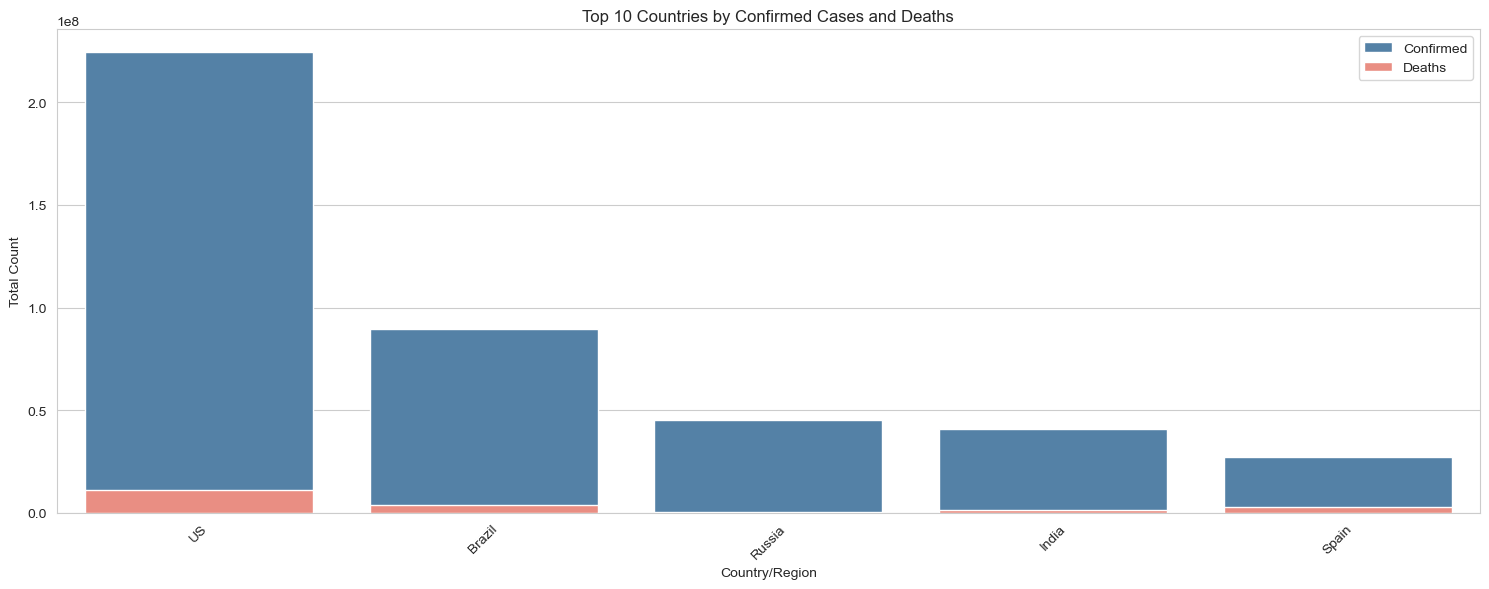

In [8]:
# Confirmed cases and deaths
# Get top 10 countries by Confirmed cases
top10 = country_totals.sort_values(by='Confirmed', ascending=False).head(10).reset_index()

# Plot
sns.set_style('whitegrid')
plt.figure(figsize=(15, 6))
sns.barplot(x='Country/Region', y='Confirmed', data=top10, color='steelblue', label='Confirmed')
sns.barplot(x='Country/Region', y='Deaths', data=top10, color='salmon', label='Deaths')
plt.title('Top 10 Countries by Confirmed Cases and Deaths')
plt.xlabel('Country/Region')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

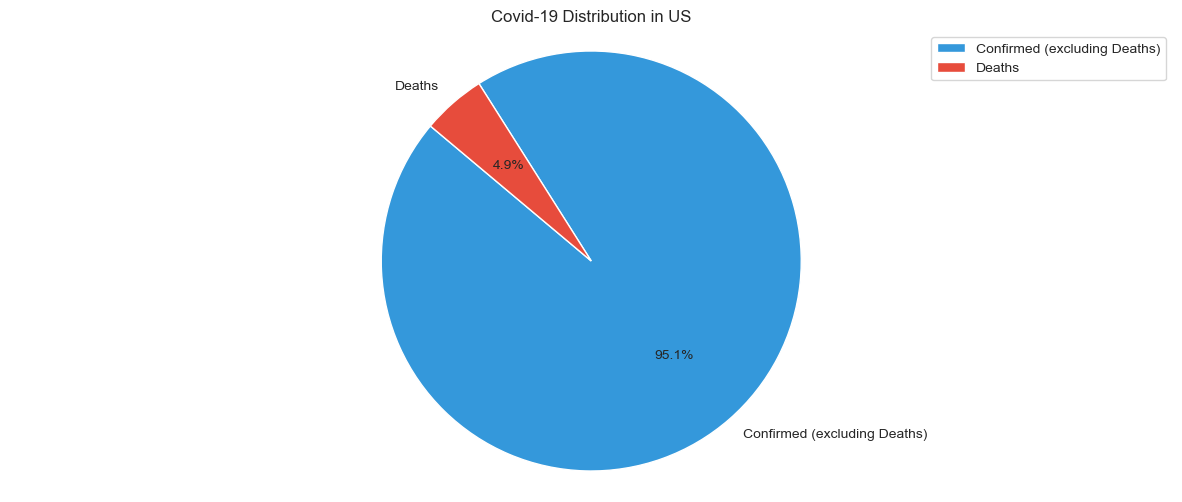

In [9]:
# Highest confirmed cases and deaths
# Find the country with the highest confirmed cases
top_country = country_totals['Confirmed'].idxmax()
top_data = country_totals.loc[top_country]

# Pie chart data
labels = ['Confirmed (excluding Deaths)', 'Deaths']
sizes = [top_data['Confirmed'] - top_data['Deaths'], top_data['Deaths']]
colors = ['#3498db', '#e74c3c']

# Plotting
plt.figure(figsize=(15, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title(f'Covid-19 Distribution in {top_country}')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend()
plt.show()

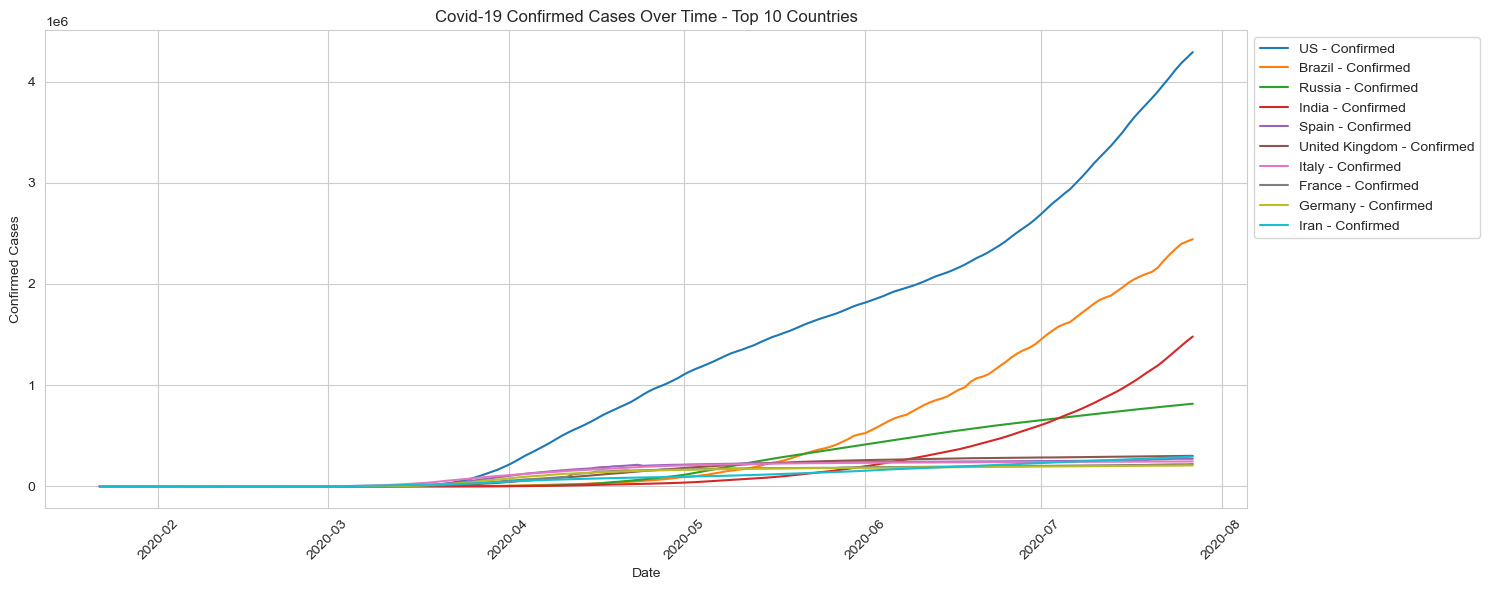

In [10]:
# Trend Analysis
# Get total confirmed cases by country
top10_countries = df.groupby('Country/Region')['Confirmed'].sum().sort_values(ascending=False).head(10).index.tolist()

# Filter for top 10 countries
df_10 = df[df['Country/Region'].isin(top10_countries)]

# Group by Country and Date
trend_data = df_10.groupby(['Country/Region', 'Date'])[['Confirmed', 'Deaths']].sum().reset_index()

# Plotting
plt.figure(figsize=(15, 6))

for country in top10_countries:
    data = trend_data[trend_data['Country/Region'] == country]
    plt.plot(data['Date'], data['Confirmed'], label=f"{country} - Confirmed")

plt.title('Covid-19 Confirmed Cases Over Time - Top 10 Countries')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

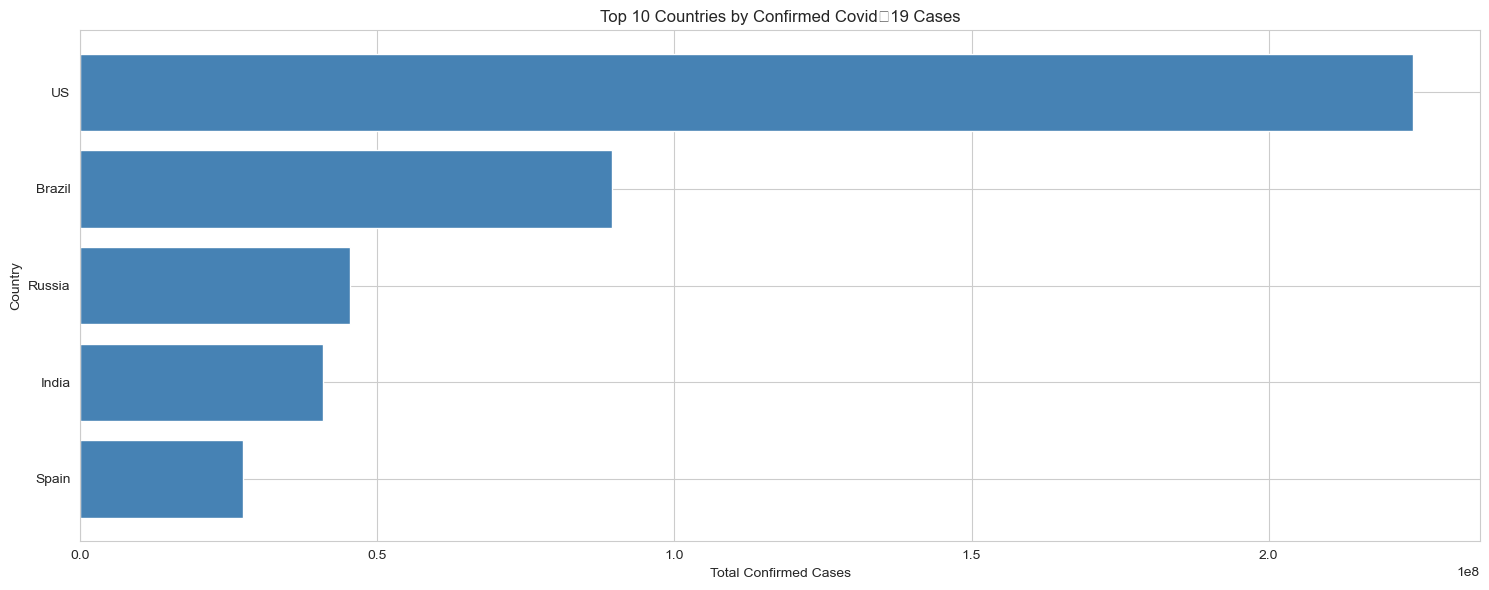

In [11]:
# Top 10 countries by confirmed cases
top_confirmed = country_totals.sort_values(by='Confirmed', ascending=False).head(10)

# ---- Plot 1: Confirmed Cases ----
plt.figure(figsize=(15, 6))
plt.barh(top_confirmed.index[::-1], top_confirmed['Confirmed'][::-1], color='steelblue')
plt.title('Top 10 Countries by Confirmed Covid‑19 Cases')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

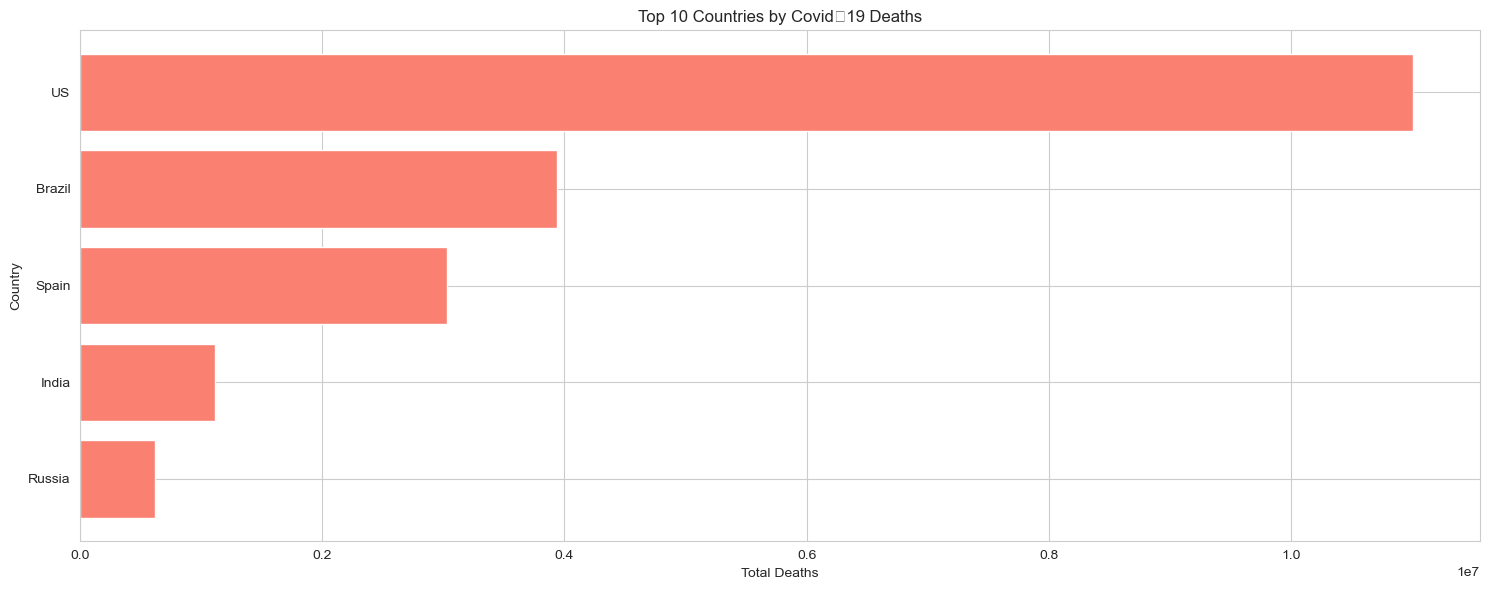

In [12]:
# Top 10 countries by deaths
top_deaths = country_totals.sort_values(by='Deaths', ascending=False).head(10)

# ---- Plot 2: Deaths ----
plt.figure(figsize=(15, 6))
plt.barh(top_deaths.index[::-1], top_deaths['Deaths'][::-1], color='salmon')
plt.title('Top 10 Countries by Covid‑19 Deaths')
plt.xlabel('Total Deaths')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

In [13]:
# Cases per Population
# Check if 'Population' column exists
if 'Population' in df.columns:
    # Get latest data per country (assumes Date is already datetime)
    df['Date'] = pd.to_datetime(df['Date'])
    latest_df = df.sort_values('Date').groupby('Country/Region').last().reset_index()

    # Calculate confirmed cases per 1,000 people
    latest_df['Cases_per_1000'] = (latest_df['Confirmed'] / latest_df['Population']) * 1000

    # Display top rows
    result = latest_df[['Country/Region', 'Confirmed', 'Population', 'Cases_per_1000']].sort_values(by='Cases_per_1000', ascending=False)
    print(result.head(10))
else:
    print("The dataset does not contain a 'Population' column.")

The dataset does not contain a 'Population' column.


# 3.Comparative Analysis

In [14]:
# Country-wise Comparison
# Group by country and sum confirmed and deaths
country_summary = df.groupby('Country/Region')[['Confirmed', 'Deaths']].sum()

# Get country with the highest confirmed cases
highest_confirmed = country_summary['Confirmed'].idxmax()
lowest_confirmed = country_summary['Confirmed'].idxmin()

# Get country with the highest deaths
highest_deaths = country_summary['Deaths'].idxmax()
lowest_deaths = country_summary['Deaths'].idxmin()

# Display results
print("Highest Confirmed Cases:")
print(f"{highest_confirmed}: {country_summary.loc[highest_confirmed, 'Confirmed']:,}")

print("Lowest Confirmed Cases:")
print(f"{lowest_confirmed}: {country_summary.loc[lowest_confirmed, 'Confirmed']:,}")

print("\Highest Deaths:")
print(f"{highest_deaths}: {country_summary.loc[highest_deaths, 'Deaths']:,}")

print("Lowest Deaths:")
print(f"{lowest_deaths}: {country_summary.loc[lowest_deaths, 'Deaths']:,}")

Highest Confirmed Cases:
US: 224,345,948
Lowest Confirmed Cases:
Western Sahara: 901
\Highest Deaths:
US: 11,011,411
Lowest Deaths:
Bhutan: 0


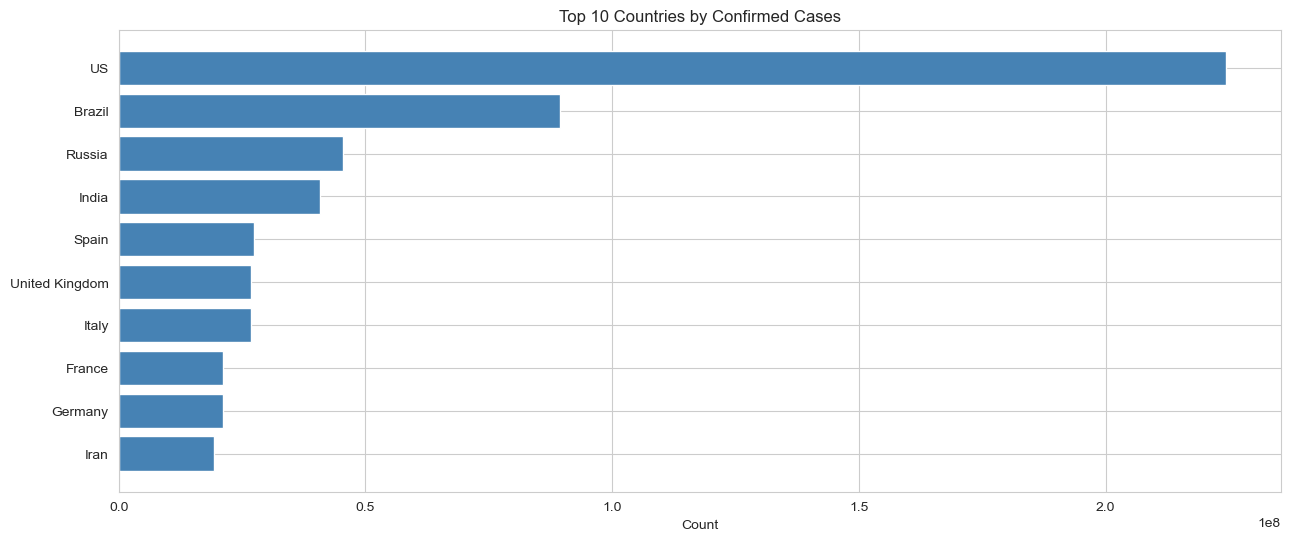

In [15]:
# Group by country and sum the values
summary = df.groupby('Country/Region')[['Confirmed', 'Deaths']].sum().sort_values(by='Confirmed', ascending=False)

# Get top 10 countries by Confirmed cases
top10 = summary.head(10).reset_index()

# Plot top 10
plt.figure(figsize=(15, 6))
plt.barh(top10['Country/Region'], top10['Confirmed'], color='steelblue', label='Confirmed')
plt.xlabel('Count')
plt.title('Top 10 Countries by Confirmed Cases')
plt.gca().invert_yaxis()
plt.show()

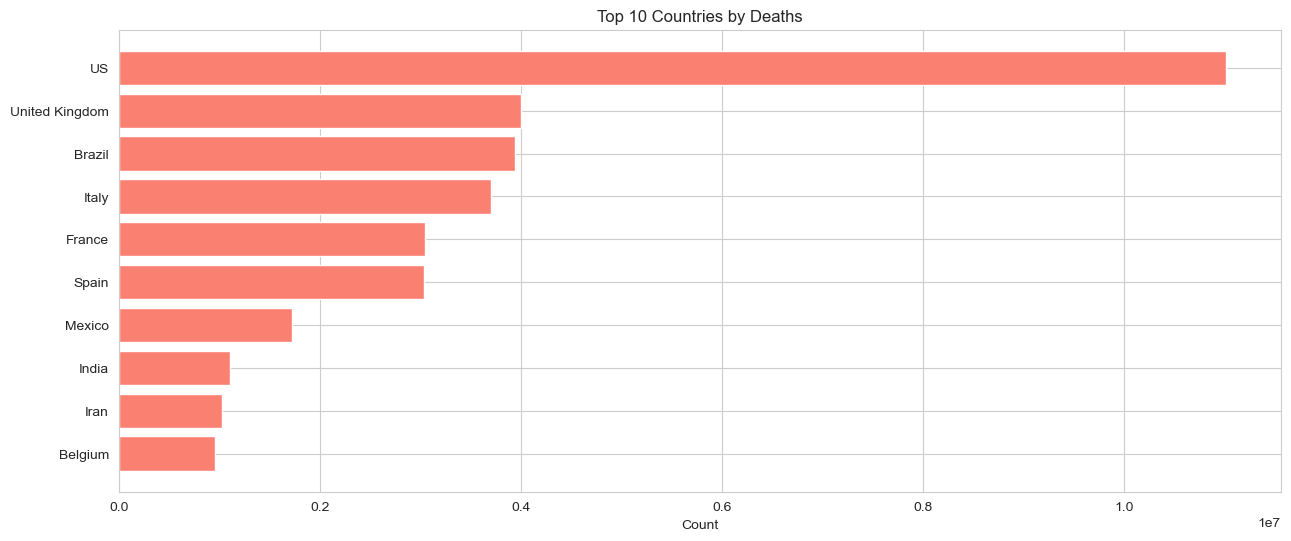

In [16]:
# Group by country and sum the values
summary = df.groupby('Country/Region')[['Confirmed', 'Deaths']].sum().sort_values(by='Deaths', ascending=False)

# Get top 10 countries by Confirmed cases
top10 = summary.head(10).reset_index()

# Plot top 10
plt.figure(figsize=(15, 6))
plt.barh(top10['Country/Region'], top10['Deaths'], color='salmon', label='Deaths')
plt.xlabel('Count')
plt.title('Top 10 Countries by Deaths')
plt.gca().invert_yaxis()
plt.show()

# Testing & Positivity Rates
# There is no 'Tests' columns. That's why we can't performed correlation between 'Tests' and 'Confirmed'...

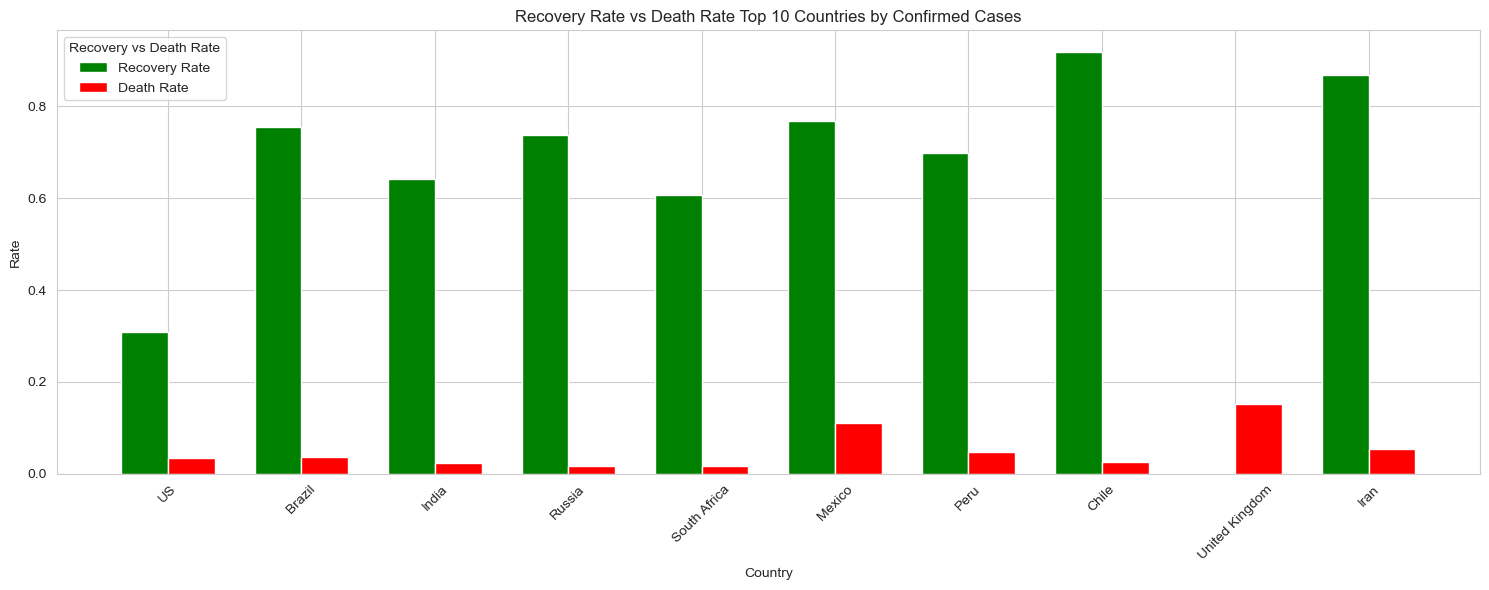

In [17]:
# Recovery vs. Death Rate
# Get the latest record per country
latest_df = df.sort_values('Date').groupby('Country/Region').tail(1)

# Calculate Recovery Rate and Death Rate
latest_df['Recovery Rate'] = latest_df['Recovered'] / latest_df['Confirmed']
latest_df['Death Rate'] = latest_df['Deaths'] / latest_df['Confirmed']

# Handle infinities and NaNs
latest_df.replace([float('inf'), float('-inf')], 0, inplace=True)
latest_df.fillna(0, inplace=True)

# Select relevant columns and sort by Confirmed cases
comparison_df = latest_df[['Country/Region', 'Confirmed', 'Recovered', 'Deaths', 'Recovery Rate', 'Death Rate']]
comparison_df_sorted = comparison_df.sort_values(by='Confirmed', ascending=False)

# Plotting
top_countries = comparison_df_sorted.head(10)
bar_width = 0.35
x = range(len(top_countries))

# Creating plot
plt.figure(figsize=(15, 6))
plt.bar(x, top_countries['Recovery Rate'], width=bar_width, label='Recovery Rate', color='green')
plt.bar([i + bar_width for i in x], top_countries['Death Rate'], width=bar_width, label='Death Rate', color='red')
plt.xlabel('Country')
plt.ylabel('Rate')
plt.title('Recovery Rate vs Death Rate Top 10 Countries by Confirmed Cases')
plt.xticks([i + bar_width / 2 for i in x], top_countries['Country/Region'], rotation=45)
plt.legend(title='Recovery vs Death Rate')
plt.tight_layout()
plt.show()

# 4. Predictive Modeling

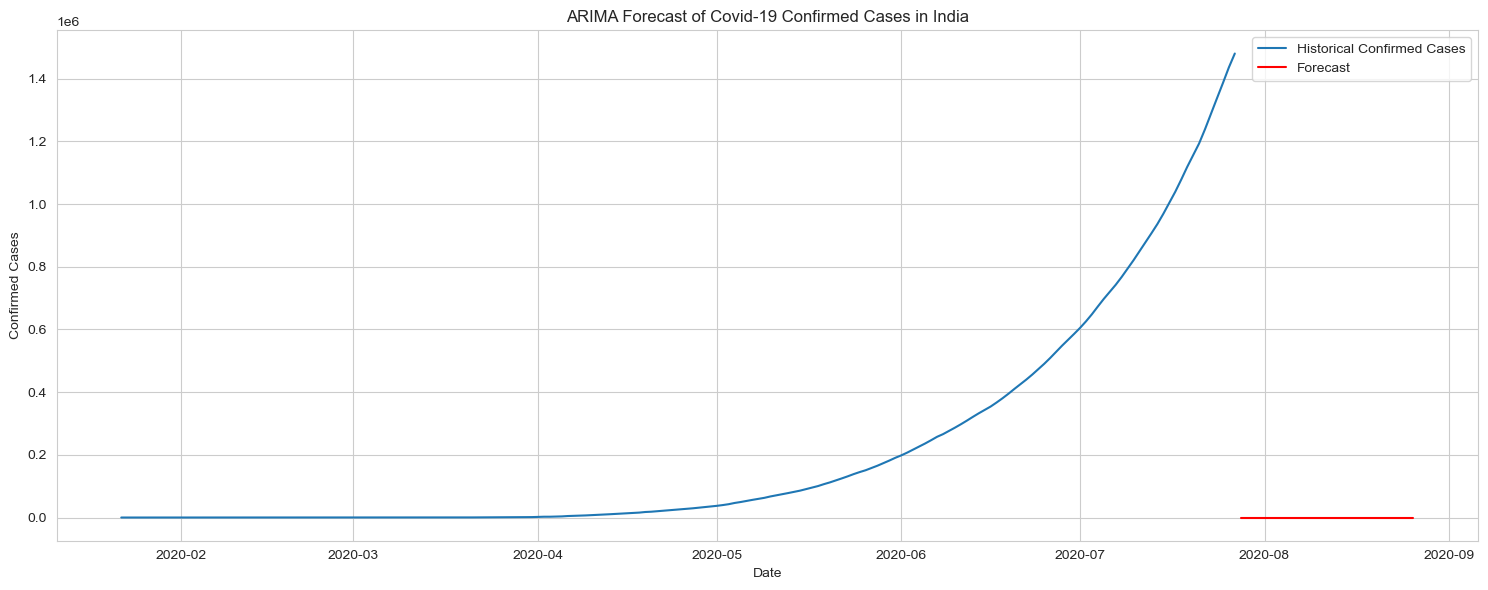

In [18]:
# Prediction of Future Cases
register_matplotlib_converters()

# Filter for India
india_df = df[df['Country/Region'] == 'India']
india_ts = india_df.groupby('Date')['Confirmed'].sum()

# Fit the ARIMA model
# (p, d, q) are parameters: start with (2, 1, 2) and tune
model = ARIMA(india_ts, order=(2, 1, 2))
model_fit = model.fit()

# Forecast the next 30 days
forecast = model_fit.forecast(steps=30)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(india_ts, label='Historical Confirmed Cases')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title("ARIMA Forecast of Covid-19 Confirmed Cases in India")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

R² Score: 0.9288
Intercept: 7393.53, Coefficient: 0.0429


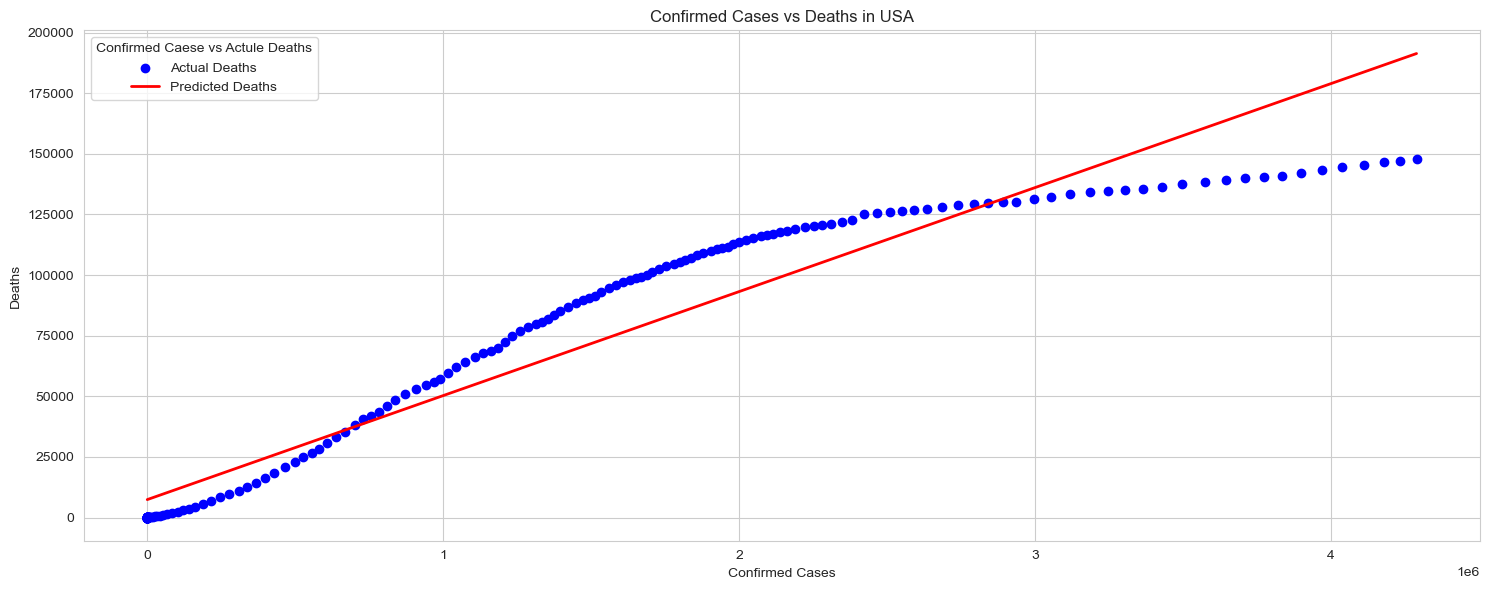

In [19]:
# Prediction of Deaths
# Filter for USA
usa_df = df[df['Country/Region'] == 'US']

# Aggregate data by Date
daily_usa = usa_df.groupby('Date')[['Confirmed', 'Deaths']].sum().reset_index()

# Prepare features and target
X = daily_usa[['Confirmed']]  # Feature
y = daily_usa['Deaths']       # Target

# Train linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict deaths based on confirmed cases
y_pred = model.predict(X)

# Evaluate model
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")
print(f"Intercept: {model.intercept_:.2f}, Coefficient: {model.coef_[0]:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.scatter(X, y, color='blue', label='Actual Deaths')
plt.plot(X, y_pred, color='red', linewidth=2, label='Predicted Deaths')
plt.title('Confirmed Cases vs Deaths in USA')
plt.xlabel('Confirmed Cases')
plt.ylabel('Deaths')
plt.legend(title='Confirmed Caese vs Actule Deaths')
plt.grid(True)
plt.tight_layout()
plt.show()

# Impact of Vaccination
# We can't do this. Because of, the 'Vacation' data is not in the data frame....

# Machine Learning Model
# We can't build a machine learning model. Because of, the 'Population' coloumn is not in the data frame...

# 5. Correlation and Causality

Pearson correlation between Confirmed Cases and Deaths: 0.9256


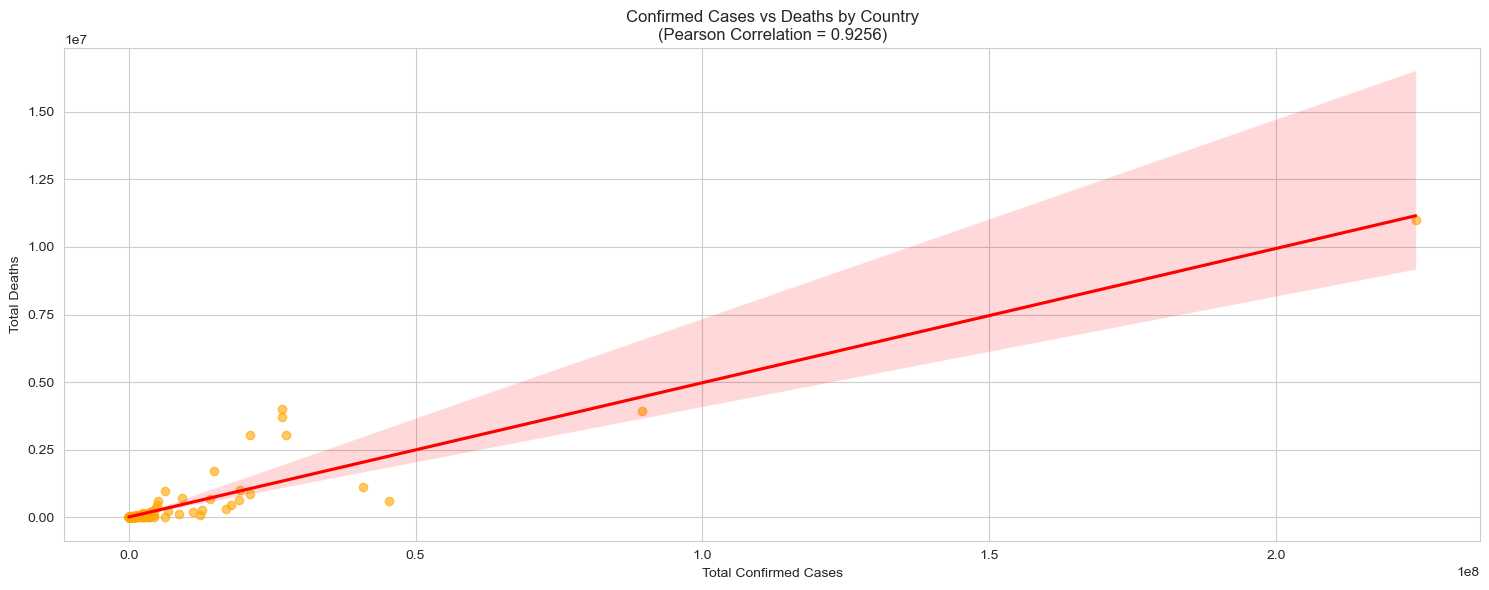

In [21]:
# Correlation between Cases & Deaths
# Group by country and sum confirmed cases and deaths
summary = df.groupby('Country/Region')[['Confirmed', 'Deaths']].sum().reset_index()

# Calculate Pearson correlation coefficient
correlation = summary['Confirmed'].corr(summary['Deaths'], method='pearson')

print(f"Pearson correlation between Confirmed Cases and Deaths: {correlation:.4f}")

# Plot with regression line
plt.figure(figsize=(15, 6))
sns.regplot(
    data=summary,
    x='Confirmed',
    y='Deaths',
    scatter_kws={'alpha': 0.6, 'color': 'orange'},
    line_kws={'color': 'red'}
)
plt.title(f"Confirmed Cases vs Deaths by Country\n(Pearson Correlation = {correlation:.4f})")
plt.xlabel("Total Confirmed Cases")
plt.ylabel("Total Deaths")
plt.grid(True)
plt.tight_layout()
plt.show()

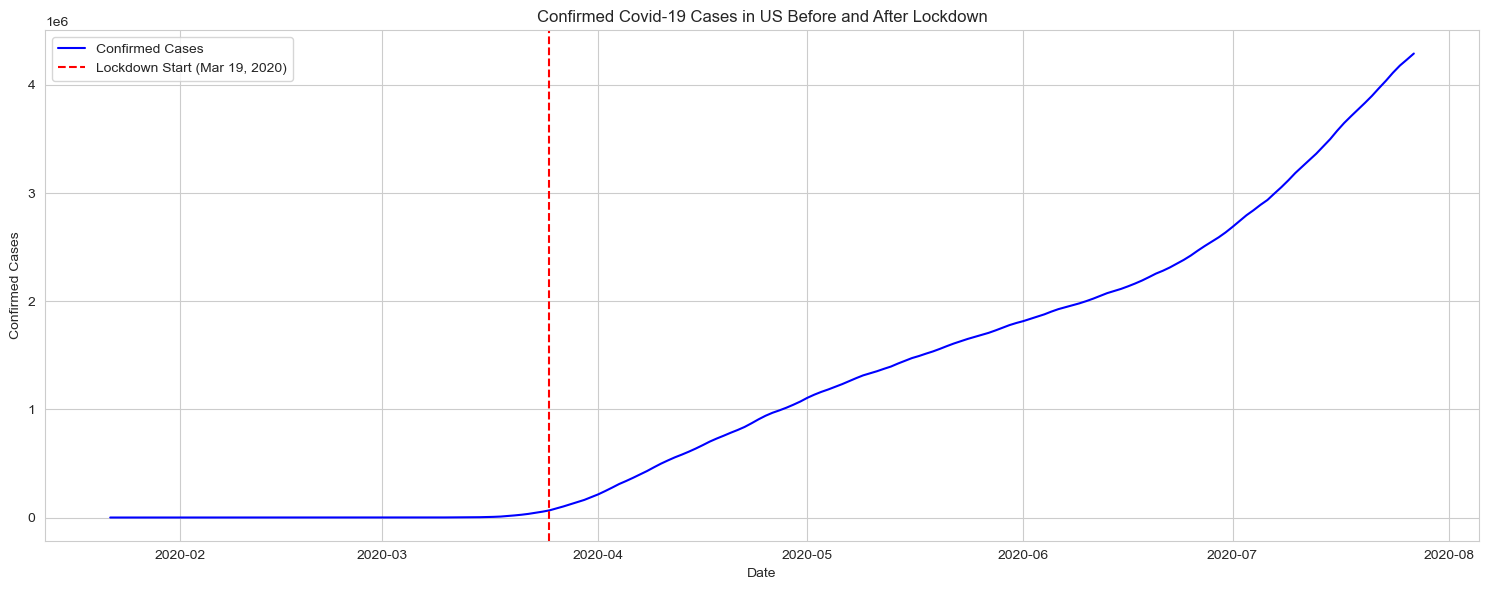

T-test statistic: -18.04
P-value: 0.0000
Statistically significant difference in cases before and after lockdown.


In [22]:
# Effect of Social Distancing or Lockdown
# Filter for India
US_df = df[df['Country/Region'] == 'US'].groupby('Date')['Confirmed'].sum().reset_index()

# Set lockdown date
lockdown_date = pd.to_datetime("2020-03-25")

# Split data into before and after lockdown
before_lockdown = US_df[US_df['Date'] < lockdown_date]['Confirmed']
after_lockdown = US_df[US_df['Date'] >= lockdown_date]['Confirmed']

# Perform t-test (optional)
t_stat, p_value = ttest_ind(before_lockdown, after_lockdown, equal_var=False)

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(US_df['Date'], US_df['Confirmed'], label='Confirmed Cases', color='blue')
plt.axvline(lockdown_date, color='red', linestyle='--', label='Lockdown Start (Mar 19, 2020)')
plt.title('Confirmed Covid-19 Cases in US Before and After Lockdown')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output result
print(f"T-test statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Statistically significant difference in cases before and after lockdown.")
else:
    print("No statistically significant difference found.")


# 6. Visualization

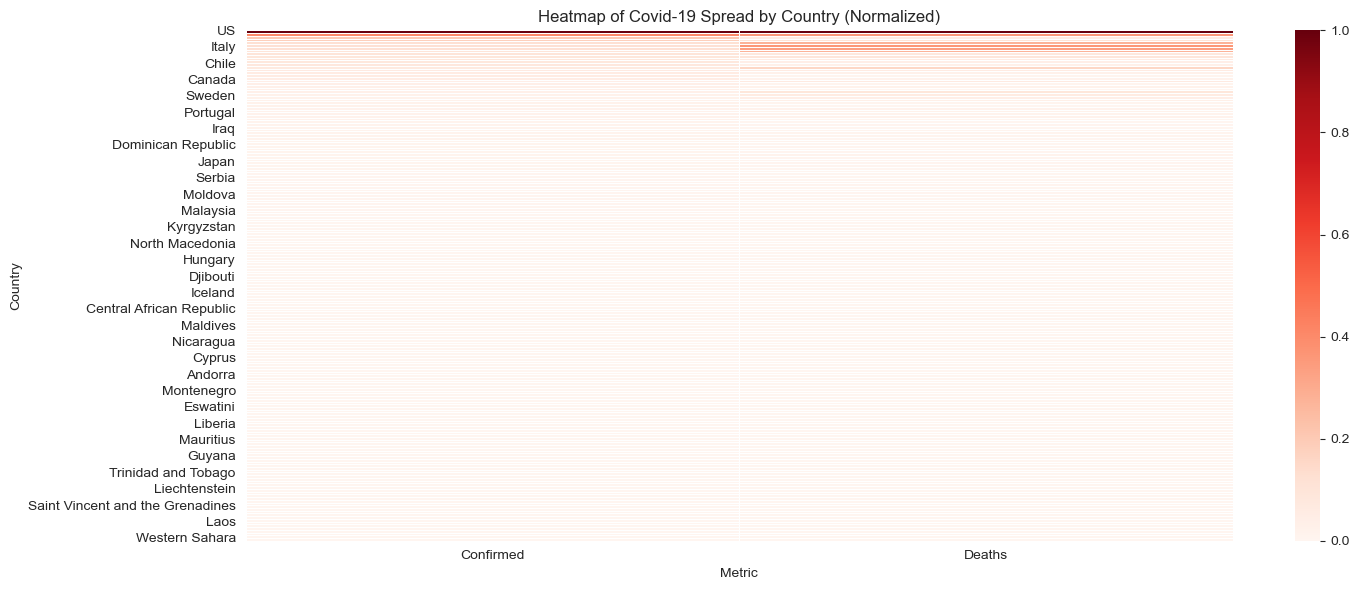

In [23]:
# Heatmap for Geographical Spread
# Group by country and sum Confirmed and Deaths
summary = df.groupby('Country/Region')[['Confirmed', 'Deaths']].sum()

# Normalize values for better visual contrast (optional)
summary_normalized = summary.apply(lambda x: x / x.max(), axis=0)

# Create heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(summary_normalized.sort_values('Confirmed', ascending=False), 
            annot=False, cmap="Reds", linewidths=.5)
plt.title("Heatmap of Covid-19 Spread by Country (Normalized)")
plt.xlabel("Metric")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

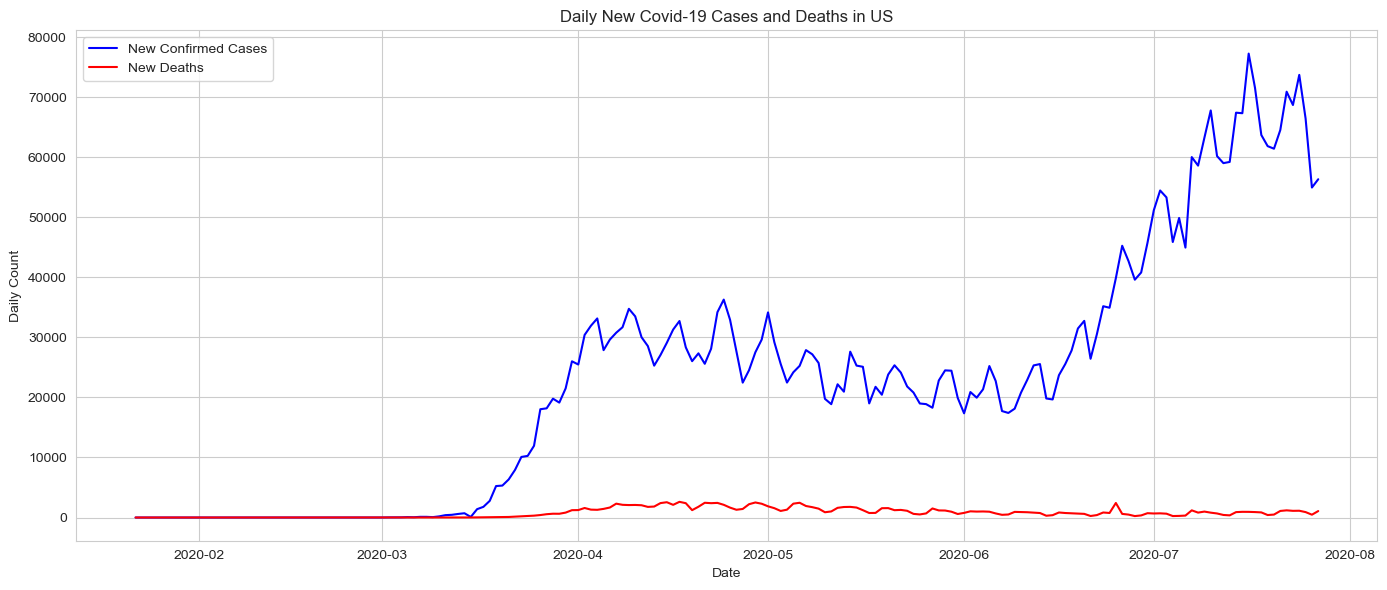

In [24]:
# Line Charts for Trends
# Filter for a specific country (e.g., India)
country = "US"
country_df = df[df['Country/Region'] == country].groupby('Date')[['Confirmed', 'Deaths']].sum().reset_index()

# Calculate new daily cases and deaths
country_df['New_Confirmed'] = country_df['Confirmed'].diff().fillna(0)
country_df['New_Deaths'] = country_df['Deaths'].diff().fillna(0)

# Plotting
plt.figure(figsize=(14, 6))

plt.plot(country_df['Date'], country_df['New_Confirmed'], label='New Confirmed Cases', color='blue')
plt.plot(country_df['Date'], country_df['New_Deaths'], label='New Deaths', color='red')

plt.title(f"Daily New Covid-19 Cases and Deaths in {country}")
plt.xlabel("Date")
plt.ylabel("Daily Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

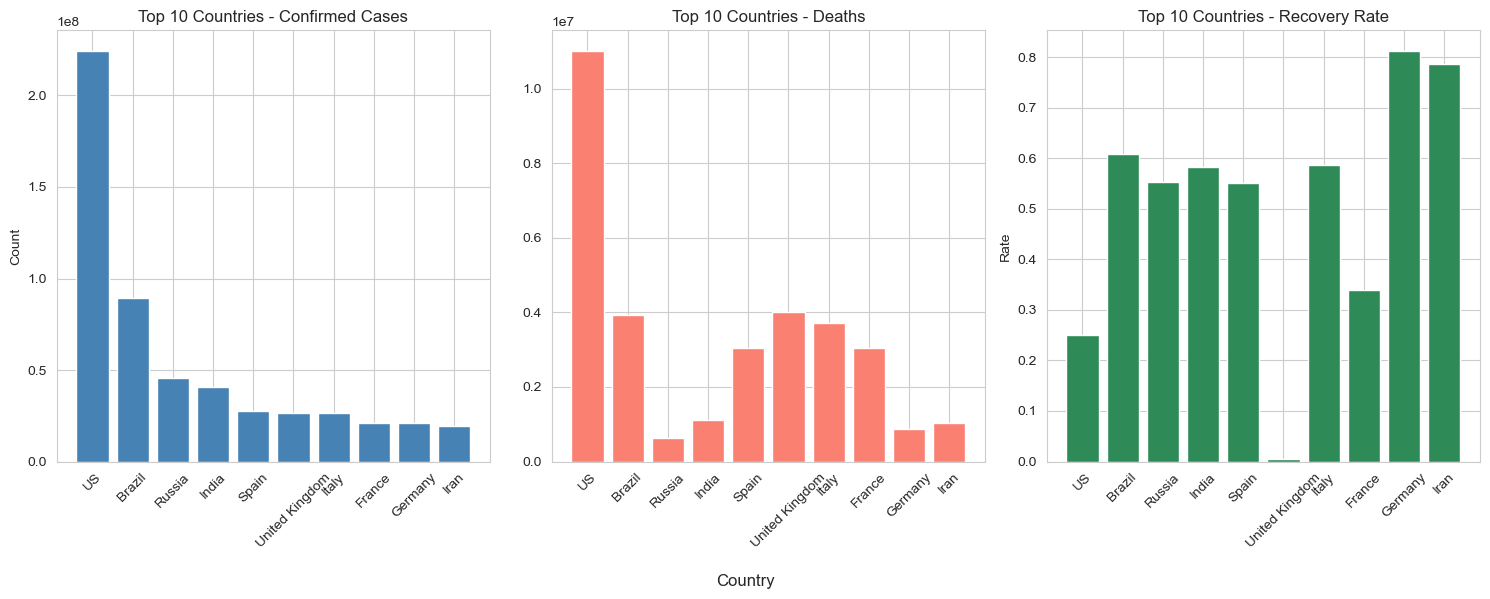

In [25]:
# Bar Charts
# Group by country and get the latest total values
summary = df.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Calculate Recovery Rate
summary['Recovery_Rate'] = summary['Recovered'] / summary['Confirmed']

# Select top 10 countries by confirmed cases
top10 = summary.sort_values(by='Confirmed', ascending=False).head(10)

# Plotting
fig = plt.figure(figsize=(15, 6))

# Confirmed cases
plt.subplot(1, 3, 1)
plt.bar(top10['Country/Region'], top10['Confirmed'], color='steelblue')
plt.title('Top 10 Countries - Confirmed Cases')
plt.xticks(rotation=45)
plt.ylabel('Count')

# Deaths
plt.subplot(1, 3, 2)
plt.bar(top10['Country/Region'], top10['Deaths'], color='salmon')
plt.title('Top 10 Countries - Deaths')
plt.xticks(rotation=45)

# Recovery Rate
plt.subplot(1, 3, 3)
plt.bar(top10['Country/Region'], top10['Recovery_Rate'], color='seagreen')
plt.title('Top 10 Countries - Recovery Rate')
plt.xticks(rotation=45)
plt.ylabel('Rate')

# Shared X-axis label
fig.supxlabel("Country")  # Primary x-axis label across all subplots

plt.tight_layout()
plt.show()

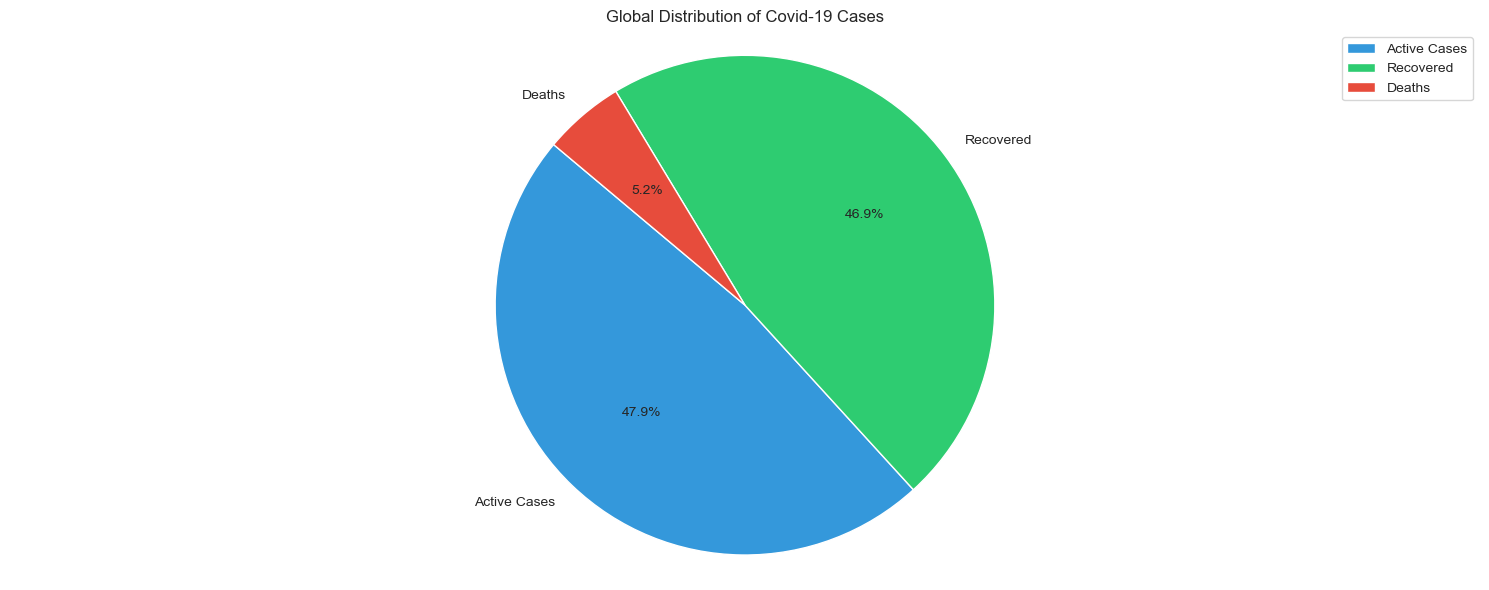

In [26]:
# Pie Chart for Cases Distribution
# Aggregate global totals
global_totals = df[['Confirmed', 'Recovered', 'Deaths']].sum()

# Calculate active cases (Confirmed - Recovered - Deaths)
active_cases = global_totals['Confirmed'] - global_totals['Recovered'] - global_totals['Deaths']

# Prepare labels and sizes
labels = ['Active Cases', 'Recovered', 'Deaths']
sizes = [active_cases, global_totals['Recovered'], global_totals['Deaths']]
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Pie chart with only percentages
plt.figure(figsize=(15, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Global Distribution of Covid-19 Cases')
plt.axis('equal')
plt.tight_layout()
plt.legend()
plt.show()

# 7. Advanced Analysis

# Clustering of Countries
# This KMeans clustering can't be performed. Becasue, the 'Population' coloumn is not in the data frame...

# Risk Factor Analysis
# We can not performed correlation between population density. Becasue, the 'Population' coloumn is not in the data frame...